In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from model import SRNets, SRNet, AutoLUT, round_func
import sys
sys.path.insert(0, "../")
from common.network import MuLUTUnit, SRNet, Residual, AutoSample
import torch
import numpy as np
from torch.nn import functional as F
from PIL import Image
from matplotlib import pyplot as plt
import torchvision

In [22]:
network=SRNets(1, 3).cuda().eval()
ckpt=torch.load("../models/no_res_bug/auto-sample-gelu-1x3/Model_700000.pth", weights_only=False)
network.load_state_dict(ckpt.state_dict(), strict=True)
lutnet=AutoLUT("../models/no_res_bug/auto-sample-gelu-1x3/", 2, 1, 3).cuda().eval()

In [23]:
nwsam=network.s0_0.sampler
sfmw=F.softmax(nwsam.sampler.weight.view(-1, nwsam.nw), dim=1).view_as(nwsam.sampler.weight)
hope=(nwsam.sampler.weight==lutnet.s0_0_sampler.sampler.weight).all()
if hope==False:
    print(nwsam.sampler.weight)
    print(lutnet.s0_0_sampler.sampler.weight)
assert hope

torch.Size([1, 3, 128, 128]) tensor(0., device='cuda:0') tensor(1., device='cuda:0')
torch.Size([1, 3, 512, 512]) tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(30.8325)


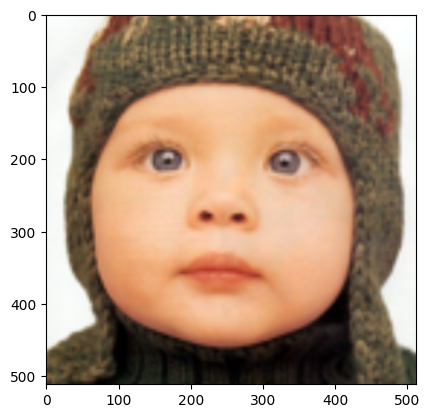

In [4]:
name="baby"
label=np.array(Image.open(f"../data/SRBenchmark/Set5/HR/{name}.png"))
img=np.array(Image.open(f"../data/SRBenchmark/Set5/LR_bicubic/X4/{name}x4.png"))
N,H,W,C=1, *img.shape

img=torch.Tensor(np.transpose(img, (2, 0, 1)).reshape(N,C,H,W)) / 255.0
img=img.cuda()
label=torch.Tensor(np.transpose(label, (2, 0, 1)).reshape(N,C,H*4,W*4)) / 255.0
label=label.cuda()

def showimg(image):
    # N,C,H,W -> H,W,C
    image=np.array(image.detach().cpu())
    N,C,H,W=image.shape
    assert N==1
    image=image.reshape(C,H,W).transpose(1,2,0)
    plt.figure()
    plt.imshow(image, vmin=0, vmax=1)

def psnr(a,b):
    from common.utils import PSNR, _rgb2ycbcr
    def transform(x):
        x=x*255
        x=x.squeeze(0)
        x=torch.transpose(x, 0, 1)
        x=torch.transpose(x, 1, 2)
        x=torch.clamp(x, 0, 255)
        x=torch.round(x).to(torch.uint8)
        return x

    a=transform(a)
    b=transform(b)
    left, right = _rgb2ycbcr(a)[:,:,0], _rgb2ycbcr(b)[:,:,0]
    result=PSNR(left, right, 4)
    return result,a,b

upscaler=torchvision.transforms.Resize((H*4, W*4))

# showimg(img)
# showimg(label)
print(img.shape, img.min(), img.max())
print(label.shape, label.min(), label.max())
p,_a,_b=psnr(upscaler(img), label)
print(p)
plt.imshow(_a.detach().cpu().numpy())

In [5]:
sampler=AutoSample(3).cuda()

# Non-LUT method
srmodule=SRNet(3)
unfolded,shape=srmodule.unfold(img)
sampled=sampler(unfolded)
print("sampled shape (mulutunit input)", sampled.shape)

# LUT method
a,b,c,d=lutnet.sample(sampler, img)
up=torch.cat((a,b), 2)
down=torch.cat((c,d), 2)
lutsam=torch.cat((up,down), 3)

sampled shape (mulutunit input) torch.Size([47628, 1, 2, 2])


In [6]:
print("SR")
print(N*C*(H-3+1)*(W-3+1))
print("unfolded shape", unfolded.shape)
print("sampled shape", sampled.shape) # what goes into mulutunit
sampled_reshaped=sampled.reshape(N, C, H-3+1, W-3+1, 2, 2)
print("reshaped", sampled_reshaped.shape)
print("LUT")
print("sampled shape", lutsam.shape)

# upper left
ulsr=sampled_reshaped[:,:,:,:,0,0]
ullut=a
assert ulsr.shape==ullut.shape
assert (ulsr==ullut).all()

# upper right
ursr=sampled_reshaped[:,:,:,:,0,1]
urlut=b
assert ursr.shape==urlut.shape
assert (ursr==urlut).all()

# bottom left
blsr=sampled_reshaped[:,:,:,:,1,0]
bllut=c
assert blsr.shape==bllut.shape
assert (blsr==bllut).all()

# bottom right
brsr=sampled_reshaped[:,:,:,:,1,1]
brlut=d
assert brsr.shape==brlut.shape
assert (brsr==brlut).all()

print("Sampling is same between LUT and CNN method")

SR
47628
unfolded shape torch.Size([47628, 1, 3, 3])
sampled shape torch.Size([47628, 1, 2, 2])
reshaped torch.Size([1, 3, 126, 126, 2, 2])
LUT
sampled shape torch.Size([1, 3, 252, 252])
Sampling is same between LUT and CNN method


sr psnr: tensor(19.9940)
lut psnr: tensor(19.9188)


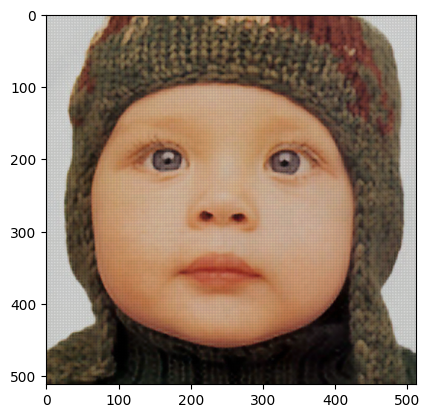

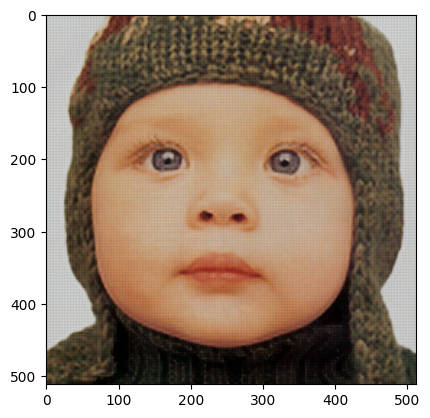

In [12]:
sr_ups=network.forward(img, phase='valid')/255.0
sr_ups=torch.clamp(sr_ups, 0, 1)
lut_ups=lutnet.forward(img)
showimg(sr_ups)
showimg(lut_ups)
psnrs, sr_tr, label_tr = psnr(sr_ups, label)
print("sr psnr:",psnrs)
lut_psnr, lut_tr, label_lut_tr = psnr(lut_ups, label)
print("lut psnr:",lut_psnr)


torch.Size([1, 3, 130, 130])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0..1.0000458].


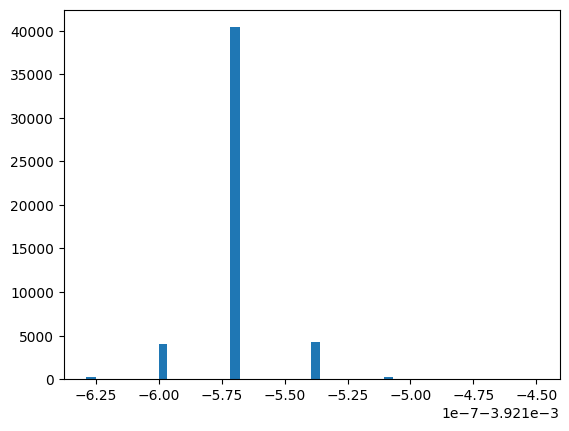

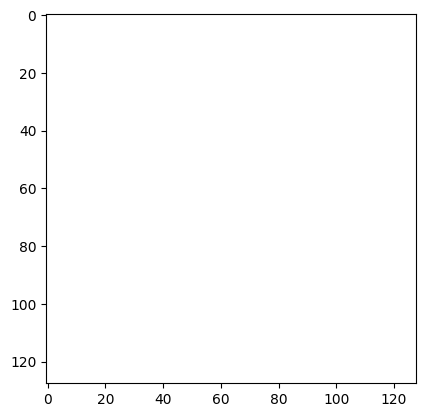

In [8]:
# Without rotation
pad=network.sample_size-1
padded=F.pad(img, (0,pad,0,pad), mode='replicate')
display(padded.shape)

# SRNet, s0_0
module=network.s0_0
sr_out=module(padded, None)
sr_norm=(sr_out+1)/2

# LUT, s0_0
luweight=lutnet.weight_s0_0
lutsamp=lutnet.s0_0_sampler
lutres=lutnet.s0_0_residual
lutpred=lutnet.InterpTorchBatch(luweight, lutres, lutsamp, 1,padded*255, None, pad)
lut_norm=(lutpred+128)/255

diff=sr_norm-lut_norm
plt.figure()
plt.hist(diff.reshape(-1).detach().cpu().numpy(), bins=50)
showimg(diff/diff.max())

In [9]:
display(sr_norm.max())
display(lut_norm.max())

tensor(8.9407e-08, device='cuda:0', grad_fn=<MaxBackward1>)

tensor(0.0039, device='cuda:0', grad_fn=<MaxBackward1>)

It seems that SR and LUT get very different results, even without rotation, only MuLUTUnit. 

Let's dive deeper to see what's wrong

What's involved:
- AutoSample (verified before, no problem)
- Residual (not really, first stage)
- CNN/LUT (shouldn't go wrong, unmodified code)

In [10]:
import torch

interval=4
q=2**interval
L=2**(8-interval)+1

mapping=torch.zeros((L,L,L,L), dtype=torch.int32)-1

idx=0
for a in range(L):
    for b in range(L):
        for c in range(L):
            for d in range(L):
                if a<=b<=c<=d:
                    mapping[a,b,c,d]=idx
                    idx+=1
print(f"Used {idx}, total {L**4}, ratio {idx/(L**4)*100}%")

Used 4845, total 83521, ratio 5.800936291471606%


In [11]:
mapping[0,0,0,2]

tensor(2, dtype=torch.int32)